# Assignment 4 - Blackjack

In [151]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras

Load the environment

In [152]:
env = gym.make("Blackjack-v1", sab=False)

In [153]:
observation, info = env.reset()
print(observation)
print("Observation shape:", np.array(observation).shape)

(20, 9, 0)
Observation shape: (3,)


Define a policy

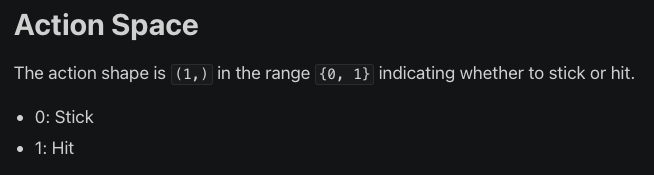

In [154]:
def define_policy(observation):
    return 0 if observation[0] >= 17 else 1

Simple policy impl:

In [155]:
num_episodes = 1000
wins = 0

for i in range(num_episodes):
    observation, info = env.reset()
    while True:
        action = define_policy(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            wins += 1 if reward > 0 else 0
            break

print(f"Win rate :{wins/num_episodes * 100:.2f}%")

Win rate :38.40%


DEEP Q-Learning

In [156]:
input_shape = (3,)
number_of_outputs = 2

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(number_of_outputs)
])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01))

/Users/dksimmay/Documents/VIA/Semester7/MAL2/Assignment_4/venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [157]:
def epsilon_greedy_policy(observation, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(number_of_outputs)
    else:
        observation = np.array(observation)
        Q_values = model.predict(observation[np.newaxis])
        return np.argmax(Q_values[0])

In [158]:
replay_memory = []

def play_one_game_step(env, observation, epsilon):
    action = epsilon_greedy_policy(observation, epsilon)
    next_observation, reward, terminated, truncated, info = env.step(action)
    replay_memory.append((observation, action, reward, next_observation, terminated))
    return next_observation, reward, terminated, truncated, info

In [159]:
discount_rate = 0.95

def training_step(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    X_batch, y_batch = [], []
    for observation, action, reward, next_observation, terminated in batch:
        observation = np.array(observation) 
        next_observation = np.array(next_observation)
        y_target = model.predict(observation[np.newaxis])
        y_target[0][action] = reward if terminated else reward + discount_rate * np.max(model.predict(next_observation[np.newaxis])[0])
        X_batch.append(observation)
        y_batch.append(y_target)
    model.fit(np.array(X_batch), np.array(y_batch), epochs=1)

In [161]:
EPISODES = 1000
rewards = []

for episode in range(EPISODES): #number of games
    observation, info = env.reset() #get initial state of the game
    while True:
        epsilon = max(1 - episode / 500, 0.01)
        observation, reward, terminated, truncated, info = play_one_game_step(env, observation, epsilon)
        if terminated or truncated:
            break

    rewards.append(reward)

    print(f"\rEpisode: {episode}, reward: {reward}", end="")

    if episode > 50:
        training_step(batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

KeyboardInterrupt: 

In [ ]:
print(f"Win rate: {sum(rewards) / len(rewards) * 100:.2f}%")